In [1]:
# Synthetic dataset
from sklearn.datasets import make_classification

# Data processing
import pandas as pd
import math
import numpy as np
import librosa
import os
from collections import Counter
import pickle
import soundfile as sf
import audioread
import shutil

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Model and performance
from sklearn.model_selection import train_test_split
import tensorflow as tf

from tensorflow.keras import layers, losses,regularizers
from sklearn.metrics import classification_report
from tensorflow.keras.layers import Dropout

In [2]:
def preprocess(dataset_path , num_mfcc=40, n_fft=2048, hop_length=1024, num_segment=1): 
    label = []
    mfccs= []
    sample_rate = 44100
    samples_per_segment= int(sample_rate/num_segment)
    error_folder = "Error_Files"
    os.makedirs(error_folder, exist_ok=True)  # Create the error folder if it doesn't exist
    for label_idx, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
        if dirpath == dataset_path:
            continue
        for f in sorted(filenames):
            if not f.endswith('.wav'):
                continue
            file_path = str(str(dirpath).split('\\')[-1])+"/"+str(f)
            file_path = os.path.join(dataset_path, file_path)
            #print(file_path)
            try:
                y, sr = librosa.load(file_path, sr=sample_rate, res_type='kaiser_fast')
            except (sf.LibsndfileError,audioread.NoBackendError) as e:
                # Print the error message
                print(f"Error loading file: {file_path}\n{str(e)}")

                # Create the label subfolder within the error folder if it doesn't exist
                label_folder = os.path.join(error_folder, str(label_idx-1))
                os.makedirs(label_folder, exist_ok=True)

                # Move the file to the label error folder
                dest_path = os.path.join(label_folder, f)
                shutil.move(file_path, dest_path)
                continue
            for n in range(num_segment):
                mfcc = librosa.feature.mfcc(y=y[samples_per_segment*n : samples_per_segment*(n+1)],
                                            sr=sr, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
                mfcc = mfcc.T
                max_length = 44
                if len(mfcc) > max_length:
                    mfcc = mfcc[:, :max_length]
                elif len(mfcc) < max_length:
                    pad_width = max_length - len(mfcc)
                    mfcc = np.pad(mfcc, pad_width=((0, pad_width), (0, 0)), mode='edge')
                mfccs.append(mfcc.tolist())
                label.append(label_idx-1)
                #print(len(mfcc))
    return mfccs, label


In [3]:
data = preprocess("Arg Numbers")

In [4]:
x=np.asarray(data[0]).astype(np.float32)
y=np.asarray(data[1]).astype(np.float32)
x.shape[0]

9982

In [5]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25)
input_shape=(X_train.shape[1],X_train.shape[2])
print('The number of records in the training dataset is', X_train.shape[0])
print('The number of records in the test dataset is', X_test.shape[0])

The number of records in the training dataset is 7486
The number of records in the test dataset is 2496


In [6]:
len(y_test)

2496

In [7]:
model=tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(128,input_shape = input_shape, return_sequences=True))
model.add(tf.keras.layers.LSTM(64))
model.add(tf.keras.layers.Dense(64, activation= "relu"))
model.add(tf.keras.layers.Dense(32, activation= "relu"))
model.add(tf.keras.layers.Dense(24, activation= "relu"))
model.add(Dropout(0.25))
model.add(tf.keras.layers.Dense(15,activation="softmax"))

In [8]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
optimiser = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'] )
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 44, 128)           86528     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 24)                792       
                                                                 
 dropout (Dropout)           (None, 24)                0         
                                                                 
 dense_3 (Dense)             (None, 15)                3

In [9]:
history = model.fit(X_train, y_train, validation_split=0.1, batch_size=16, epochs=90, verbose=2)
model.save('LSTM_1.h5')

Epoch 1/90
422/422 - 16s - loss: 2.2800 - accuracy: 0.1634 - val_loss: 1.9224 - val_accuracy: 0.2603 - 16s/epoch - 38ms/step
Epoch 2/90
422/422 - 12s - loss: 1.7812 - accuracy: 0.3264 - val_loss: 1.4894 - val_accuracy: 0.4646 - 12s/epoch - 28ms/step
Epoch 3/90
422/422 - 13s - loss: 1.4492 - accuracy: 0.4716 - val_loss: 1.2695 - val_accuracy: 0.5554 - 13s/epoch - 30ms/step
Epoch 4/90
422/422 - 13s - loss: 1.1900 - accuracy: 0.5828 - val_loss: 1.2258 - val_accuracy: 0.6128 - 13s/epoch - 30ms/step
Epoch 5/90
422/422 - 13s - loss: 1.0412 - accuracy: 0.6395 - val_loss: 0.8945 - val_accuracy: 0.6796 - 13s/epoch - 31ms/step
Epoch 6/90
422/422 - 12s - loss: 0.8981 - accuracy: 0.6965 - val_loss: 0.8661 - val_accuracy: 0.6996 - 12s/epoch - 28ms/step
Epoch 7/90
422/422 - 11s - loss: 0.8226 - accuracy: 0.7221 - val_loss: 0.8392 - val_accuracy: 0.7049 - 11s/epoch - 27ms/step
Epoch 8/90
422/422 - 11s - loss: 0.7479 - accuracy: 0.7505 - val_loss: 0.7731 - val_accuracy: 0.7570 - 11s/epoch - 27ms/step


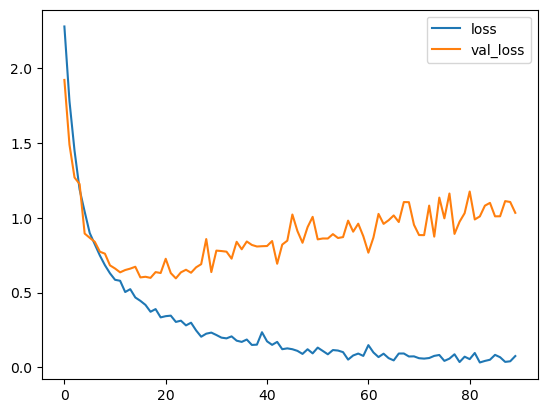

In [10]:
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()

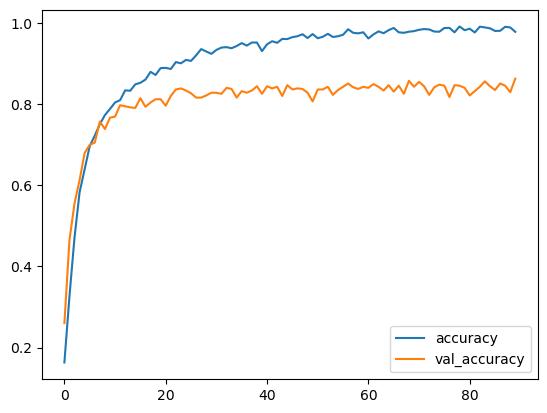

In [11]:
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.legend()

In [12]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

78/78 [==============================] - 2s 15ms/step


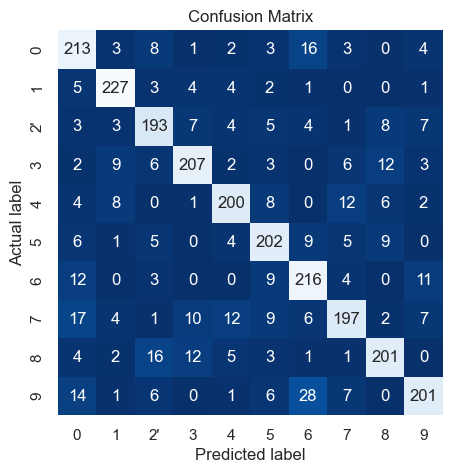

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming you have defined y_test and y_pred

mat = confusion_matrix(y_test, y_pred)
class_labels = ["0", "1", "2'", "3", "4","5","6","7","8","9"]

sns.set(font_scale=1)
plt.figure(figsize=(10, 5))
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues_r',
            xticklabels=class_labels,
            yticklabels=class_labels)

plt.xlabel('Predicted label')
plt.ylabel('Actual label')
plt.title('Confusion Matrix')

plt.show()


F1 Score: 0.8239334949278359


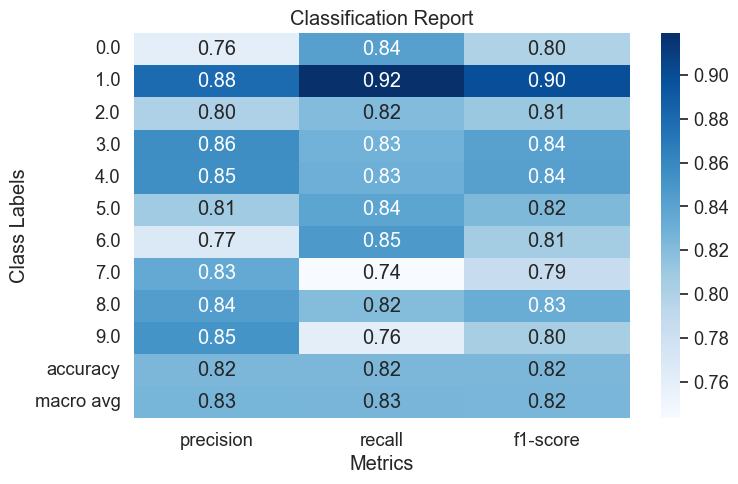

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, classification_report

# Assuming you have defined y_test and y_pred

f1 = f1_score(y_test, y_pred, average='weighted')
report = classification_report(y_test, y_pred, output_dict=True)

# Convert the report dictionary to a DataFrame for better visualization
report_df = pd.DataFrame(report).transpose()

# Create a heatmap using seaborn
sns.set(font_scale=1.2)
plt.figure(figsize=(8, 5))
sns.heatmap(report_df.iloc[:-1, :3], annot=True, fmt=".2f", cmap='Blues')

# Add title and labels to the plot
plt.title('Classification Report')
plt.xlabel('Metrics')
plt.ylabel('Class Labels')

# Print F1 score
print("F1 Score:", f1)

# Display the plot
plt.show()


In [18]:
np.sum(y_pred==y_test)/len(y_pred)

0.8241185897435898